About dataset: http://www.timeseriesclassification.com/description.php?Dataset=ECG5000
        
*         The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet. 
*         The data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation.

This dataset contains 5,000 Electrocardiograms, each with 140 data points. 
Here, we'll use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

In [49]:
#Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [50]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
print(dataframe.shape)
dataframe.head()

(4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [51]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [52]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

train_data, normal_test_data, anomalous_train_data

(array([[ 1.5225911 ,  0.0901465 , -2.3048594 , ...,  0.35594853,
         -0.48818377,  0.23199584],
        [ 0.3308203 , -2.4158494 , -4.0271171 , ...,  1.4851319 ,
          0.11905583, -2.5969672 ],
        [ 0.30674554, -1.4711163 , -2.7270273 , ...,  1.2166045 ,
          0.66671691,  1.1487992 ],
        ...,
        [-0.66551119, -2.9743856 , -4.4855485 , ...,  0.94006053,
          1.4556054 ,  0.59329534],
        [ 1.1048512 , -0.61504694, -2.4357678 , ...,  0.733911  ,
         -0.30058531, -0.22360552],
        [-2.2252716 , -4.0932167 , -3.6970107 , ...,  1.0760468 ,
          1.1871031 , -0.6945654 ]]),
 array([[ 0.29184859, -2.3295333 , -3.5677395 , ..., -0.06014076,
          0.89738638, -1.1993879 ],
        [-0.07498662, -2.7816929 , -4.0943835 , ...,  0.28878381,
          0.95021456,  0.49591025],
        [-0.09373457, -2.7663877 , -4.5579011 , ...,  1.3061383 ,
          1.7392014 ,  0.22438603],
        ...,
        [ 0.32868371, -1.3381821 , -2.4866519 , ..., -

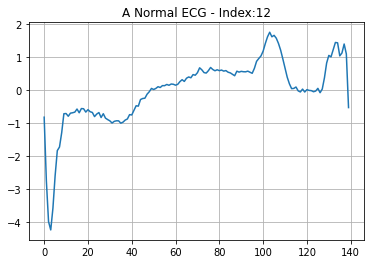

In [53]:
# Plotting a normal ECG.


plt.grid()
selected_index = np.random.randint(normal_train_data.shape[0])
plt.plot(np.arange(140), normal_train_data[selected_index])
plt.title(f"A Normal ECG - Index:{selected_index}")
plt.show()

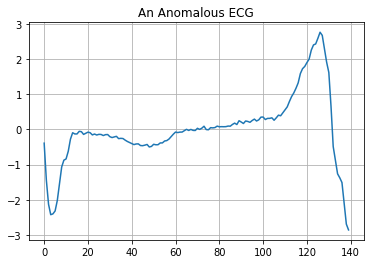

In [54]:
# Plotting an anomalous ECG.

plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [55]:
# Building the Model
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [56]:
# Compiling Model
autoencoder.compile(optimizer='adam', loss='mae')

In [57]:
# Training Model
history = autoencoder.fit(normal_train_data,
                          normal_train_data,
                          epochs=20,
                          batch_size=512,
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 38ms/step - loss: 0.7660 - val_loss: 0.7144
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.7640 - val_loss: 0.7119
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.7590 - val_loss: 0.7059
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.7471 - val_loss: 0.6944
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.7253 - val_loss: 0.6752
Epoch 6/20
5/5 [==============================] - 0s 11ms/step - loss: 0.6918 - val_loss: 0.6486
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.6489 - val_loss: 0.6186
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.6033 - val_loss: 0.5900
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.5615 - val_loss: 0.5671
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.5304 - val_loss: 0.5527
Epoch 11/20
5/5 [====================

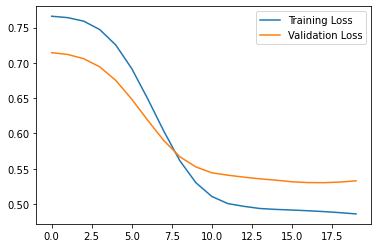

In [58]:
# Plotting Graph
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

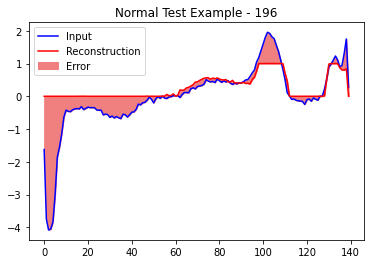

In [59]:
# Plotting Reconstructed Graph with Error Margin
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

selected_index = np.random.randint(normal_test_data.shape[0])

plt.plot(normal_test_data[selected_index], 'b')
plt.plot(decoded_data[selected_index], 'r')
plt.title(f'Normal Test Example - {selected_index}')
plt.fill_between(np.arange(140), decoded_data[selected_index], normal_test_data[selected_index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

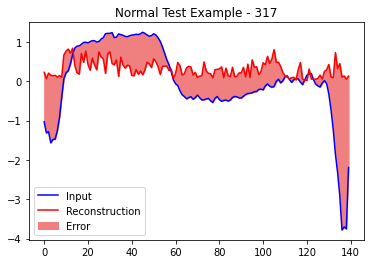

In [60]:
# Creating a similar plotfor an Anomalous Test Example.

encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

selected_index = np.random.randint(anomalous_test_data.shape[0])

plt.plot(anomalous_test_data[selected_index], 'b')
plt.plot(decoded_data[selected_index], 'r')
plt.title(f'Normal Test Example - {selected_index}')
plt.fill_between(np.arange(140), decoded_data[selected_index], anomalous_test_data[selected_index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 2ms/step


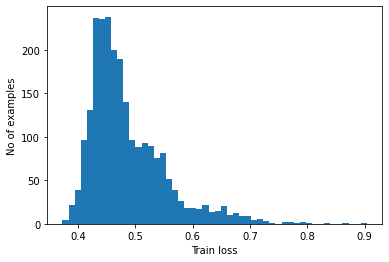

In [61]:
# MAE Graph for Training Data
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [62]:
# Defining Threshold
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.5516754030722791


14/14 [==============================] - 0s 2ms/step


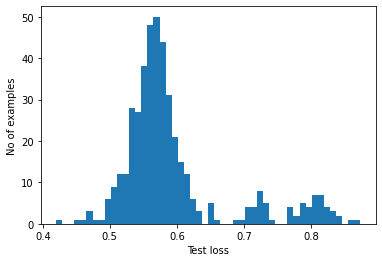

In [63]:
# MAE Graph for Testing Data
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [64]:
# Model Accuracy, Precision and Recall
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.803
Precision = 0.7970540098199672
Recall = 0.8696428571428572


Classifying an ECG as an anomaly if the reconstruction error is greater than the threshold.